In [1]:
!unzip /content/drive/MyDrive/CS9542/Project/17.zip -d /content/
!unzip /content/drive/MyDrive/CS9542/Project/17_unsolvable_same_wall_count.zip -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/17_unsolvable_same_wall_count/93765.png  
 extracting: /content/17_unsolvable_same_wall_count/93766.png  
 extracting: /content/17_unsolvable_same_wall_count/93767.png  
 extracting: /content/17_unsolvable_same_wall_count/93768.png  
 extracting: /content/17_unsolvable_same_wall_count/93770.png  
 extracting: /content/17_unsolvable_same_wall_count/93771.png  
 extracting: /content/17_unsolvable_same_wall_count/93772.png  
 extracting: /content/17_unsolvable_same_wall_count/93775.png  
 extracting: /content/17_unsolvable_same_wall_count/93776.png  
 extracting: /content/17_unsolvable_same_wall_count/93779.png  
 extracting: /content/17_unsolvable_same_wall_count/93780.png  
 extracting: /content/17_unsolvable_same_wall_count/93781.png  
 extracting: /content/17_unsolvable_same_wall_count/93782.png  
 extracting: /content/17_unsolvable_same_wall_count/93783.png  
 extracting: /content/17_unsolvable_same_wall_count/9

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
import cv2
import os
import tensorflow as tf
import math
import copy
from skimage.morphology import skeletonize
from scipy.ndimage import label
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool
import matplotlib.pyplot as plt


In [3]:
def load_images(base_path, num_images):
    """
    Load images from "solvable" and "unsolvable" folders and assign labels.

    Args:
        base_path (str): Path to the base directory containing "solvable" and "unsolvable" folders.
        num_images (int): Maximum number of images to load from each folder.

    Returns:
        list: A list of tuples (filename, image, label), where:
            - filename: The name of the image file.
            - image: The grayscale image as a NumPy array.
            - label: 0 if the image is unsolvable, 1 if solvable.
    """
    images = []
    count = 0
    for label, folder in enumerate(["solvable", "unsolvable"]):
        folder_path = os.path.join(base_path, folder) # Construct folder path
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
                images.append((filename, img, label))  # Label: 0 for "solvable", 1 for "unsolvable"
                count += 1
                if count > num_images:
                    count = 0
                    break
    print(f"Total images loaded: {len(images)}")
    return images

def preprocess_image(img):
    """
    Preprocess the maze image by converting it to binary format.

    Args:
        img (numpy.ndarray): Grayscale maze image (values range from 0 to 255).

    Returns:
        numpy.ndarray: Binary maze image (0 for walls, 1 for paths).
    """
    return img // 255  # Normalize pixel values (walls as 0, paths as 1)

In [4]:
# LR Feature Engineering Functions
def count_dead_ends(img):
    """
    Count the number of dead ends in the maze within the bottom right quarter of the maze.

    Args:
        img (numpy.ndarray): Binary maze image (0 for walls, 1 for paths).

    Returns:
        int: The number of dead ends in the maze.
    """
    skeleton = skeletonize(img > 0)  # Skeletonize the path: simplify the maze paths to 1-pixel-wide skeletons
    quarter_start = skeleton.shape[0] // 2
    dead_ends = 0
    for i in range(skeleton.shape[0] - 10, skeleton.shape[0] - 1):
        for j in range(skeleton.shape[1] - 10, skeleton.shape[1] - 1):
            if skeleton[i, j]:  # Path pixel
                # Count the number of neighboring path pixels
                neighbors = np.sum(skeleton[i-1:i+2, j-1:j+2]) - skeleton[i, j]
                if neighbors == 1:  # Dead-end has exactly 1 neighbor
                    dead_ends += 1
    return dead_ends

def count_connected_components(img):
    """
    Count the number of connected components in the maze's path regions.

    Args:
        img (numpy.ndarray): Binary maze image (0 for walls, 1 for paths).

    Returns:
        int: The number of connected components in the maze.
    """
    labeled_array, num_features = label(img[0:len(img)//4, 0:len(img)//4])  # Label connected regions of white pixels in top left n/4xn/4
    return num_features

def count_chokepoints(img):
    """
    Count the number of chokepoints (narrow paths) in the maze.

    Args:
        img (numpy.ndarray): Binary maze image (0 for walls, 1 for paths).

    Returns:
        int: The number of chokepoints in the maze.
    """
    skeleton = skeletonize(img > 0)  # Skeletonize the path
    chokepoints = 0
    for i in range(1, skeleton.shape[0] - 1):
        for j in range(1, skeleton.shape[1] - 1):
            if skeleton[i, j]:   # Check if the pixel is part of a path
                neighbors = np.sum(skeleton[i-1:i+2, j-1:j+2]) - skeleton[i, j]
                if neighbors == 2:  # Chokepoints have exactly 2 neighbors
                    chokepoints += 1
    return chokepoints

In [5]:
# Feature extraction (cheating with DFS)
def l1_dist(x, y):
    return np.sum(np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]))

def partial_dfs(img, num_branches):
    # Take an (unflattened) image of a maze. Perform depth first search, but terminating after the first num_branches dead ends. Return the closest distance to the exit found by the search (located at (285, 286)).
    img = img.astype(int)*255
    n = len(img)
    root = (1, 0)
    curr = root
    dead_ends = 0
    curr_options = 0
    best_node = root
    branches = []
    while dead_ends < num_branches:
        curr_options = 0
        if curr == (n - 2, n - 1):
            return l1_dist(curr, (n - 2, n - 1)), img
        elif l1_dist(curr, (n - 1, n - 2)) < l1_dist(best_node, (n - 2, n - 1)):
            best_node = curr
        img[curr[0], curr[1]] = 128 # mark as visited
        neighbors = [(max(curr[0] - 1, 0), curr[1]), (min(curr[0] + 1, n - 1), curr[1]), (curr[0], max(curr[1] - 1, 0)), (curr[0], min(curr[1] + 1, n - 1))]
        for neighbor in neighbors:
            if img[neighbor[0], neighbor[1]] == 255:
                branches.append(neighbor)
                curr_options += 1
        if curr_options == 0:
            dead_ends += 1
            if len(branches) == 0: # The maze is unsolvable
                return l1_dist(curr, (n - 2, n - 1)), img
            curr = branches.pop()
        else:
            if len(branches) == 0: # The maze is unsolvable
                return l1_dist(curr, (n - 2, n - 1)), img
            curr = branches.pop()
    return l1_dist(curr, (n - 2, n - 1)), img # Return the array for plots

In [6]:
def extract_features(img, num_branches_dfs):
    """
    Helper function: extract features from a maze image.

    Args:
        img (numpy.ndarray): Binary maze image.
        num_branches_dfs (int): Number of branches to use in DFS feature extraction.
    Returns:
        dict: A dictionary of extracted features.
    """
    features = {
        "dead_end_count": count_dead_ends(img),
        "connected_components": count_connected_components(img),
        "dfs_20": partial_dfs(img, num_branches_dfs)[0]
    }
    print("Feature extraction completed.")
    return features

def extract_features_for_single_image(image_data):
    """
    Extract features for a single image.

    Args:
        image_data (tuple): A tuple containing (filename, img, label).

    Returns:
        dict: A dictionary of extracted features and metadata (filename, label).
    """
    filename, img, label = image_data
    img = preprocess_image(img)  # Binary conversion
    features = extract_features(img, 10)  # Extract features
    features['filename'] = filename  # Add filename
    features['label'] = label  # Add label (solvable or unsolvable)
    return features

def parallel_feature_extraction(images_with_labels, processes=3):
    """
    Perform feature extraction in parallel.

    Args:
        images_with_labels (list): List of tuples (filename, img, label).
        processes (int): Number of processes to use.

    Returns:
        pd.DataFrame: DataFrame containing extracted features.
    """
    print(f"Extracting features for {len(images_with_labels)} images using {processes} processes...")
    with Pool(processes=processes) as pool:
        feature_dicts = pool.map(extract_features_for_single_image, images_with_labels)
    print("Feature extraction completed.")
    return pd.DataFrame(feature_dicts)

In [7]:
# Construct the engineered features and label the images
def feature_extraction_pipeline(base_path, num_images, num_branches_dfs):
    """
    Extract features and labels from maze images organized in "solvable" and "unsolvable" folders.

    Args:
        base_path (str): Path to the base directory containing the folders.
        num_images (int): Maximum number of images to load from each folder.
        num_branches_dfs (int): Number of branches to use in DFS feature extraction.

    Returns:
        pandas.DataFrame: DataFrame containing features and labels.
    """

    images = load_images(base_path, num_images)
    all_features = []
    total_images = len(images)

    for idx, (filename, img, label) in enumerate(images):
        print(f"Processing image {idx + 1}/{total_images}: {filename}")
        img = preprocess_image(img) # Convert to binary
        features = extract_features(img, num_branches_dfs) # Extract features
        features['filename'] = filename # Add filename for reference
        features['label'] = label  # Assign the label from the folder
        all_features.append(features)

    features_df = pd.DataFrame(all_features)
    return features_df

In [8]:
# Load raw image pixels to use as features and label the images
def load_data(base_path, num_images):
    images = load_images(base_path, num_images)
    features_array = np.zeros(((num_images+1) * 2, len(images[0][1])**2))
    filenames = pd.Series((num_images+1)*2)
    labels = np.ndarray((num_images+1)*2)
    total_images = len(images)
    for idx, (filename, img, label) in enumerate(images):
        print(f"Processing image {idx + 1}/{total_images}: {filename}")
        img = preprocess_image(img)
        features = img.flatten()
        features_array[idx-1] = features
        labels[idx-1] = label
        filenames[idx-1] = filename
    features_array = features_array.astype(int)
    features_df = pd.DataFrame(data=features_array)
    labels_series = pd.Series(labels)
    features_df['label'] = labels_series
    features_df['filename'] = filenames
    return features_df

In [9]:
df = feature_extraction_pipeline('/content/', 12499, 10)

Streaming output truncated to the last 5000 lines.
Processing image 22501/25000: 09666.png
Feature extraction completed.
Processing image 22502/25000: 20652.png
Feature extraction completed.
Processing image 22503/25000: 19345.png
Feature extraction completed.
Processing image 22504/25000: 71338.png
Feature extraction completed.
Processing image 22505/25000: 16025.png
Feature extraction completed.
Processing image 22506/25000: 94627.png
Feature extraction completed.
Processing image 22507/25000: 58631.png
Feature extraction completed.
Processing image 22508/25000: 12764.png
Feature extraction completed.
Processing image 22509/25000: 65968.png
Feature extraction completed.
Processing image 22510/25000: 20737.png
Feature extraction completed.
Processing image 22511/25000: 28875.png
Feature extraction completed.
Processing image 22512/25000: 05245.png
Feature extraction completed.
Processing image 22513/25000: 85034.png
Feature extraction completed.
Processing image 22514/25000: 47330.png

In [10]:
def train_and_test_model(data):
    """
    Train and test a logistic regression model on extracted features.

    Args:
        data (pandas.DataFrame): DataFrame containing features and labels.

        Returns:
        sklearn.linear_model.LogisticRegression: Trained logistic regression model.
    """
    # Prepare data
    X = data.drop(columns=['filename', 'label'])  # Features
    y = data['label']  # Labels

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train logistic regression model with best parameters
    params = [{'C': [np.exp(-5), np.exp(-4), np.exp(-3), np.exp(-2), np.exp(-1), np.exp(0), np.exp(1), np.exp(2), np.exp(3), np.exp(4), np.exp(5)]}]
    gs_lr = GridSearchCV(LogisticRegression(), param_grid=params, cv=5, scoring='accuracy')
    gs_lr.fit(X_train, y_train)

    C = gs_lr.best_params_['C']
    print(f"Best C parameter: {C}")
    print(f"Best score: {gs_lr.best_score_}")

    model_lr = LogisticRegression(C=C, solver="lbfgs", max_iter=10000)
    model_lr.fit(X_train, y_train)

    # Test the model
    y_pred = model_lr.predict(X_test)

    # Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    display(confusion_matrix(y_test, y_pred))
    return model_lr

In [11]:
model_lr = train_and_test_model(df)

Best C parameter: 0.049787068367863944
Best score: 0.9994500000000001
Accuracy: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2515
           1       1.00      1.00      1.00      2485

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



array([[2515,    0],
       [   1, 2484]])

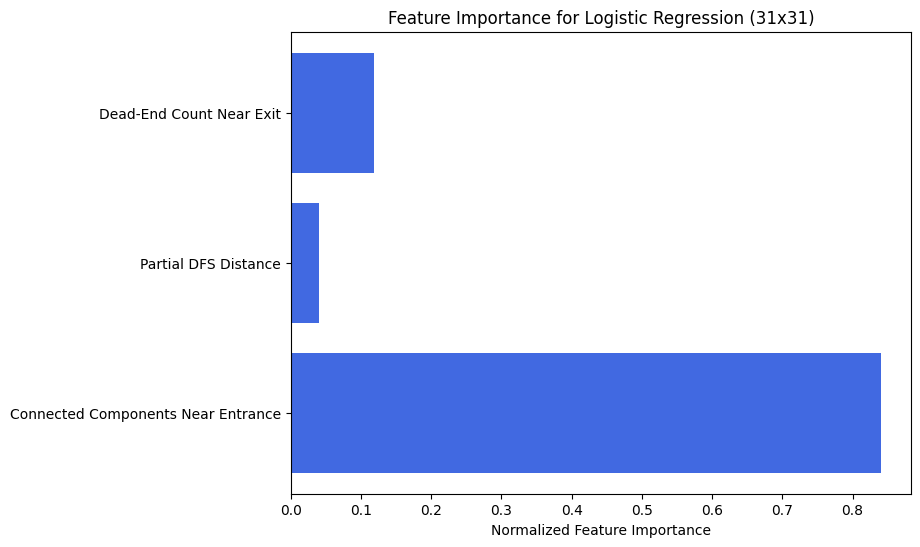

In [13]:
def plot_logistic_regression_importance(model, feature_names):
    """
    Plot a bar chart of feature importance for logistic regression.

    Args:
        model: Trained logistic regression model (from sklearn).
        feature_names (list): Names of the features used in training.
    """
    # Extract the coefficients of the logistic regression model
    importance = model.coef_[0]  # Coefficients for each feature
    feature_importance = np.abs(importance)  # Take absolute values for magnitude
    normalized_importance = feature_importance / feature_importance.sum()  # Normalize for scale

    # Plot the bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(feature_names, normalized_importance, color='royalblue')
    plt.xlabel("Normalized Feature Importance")
    plt.title("Feature Importance for Logistic Regression (31x31)")
    plt.gca().invert_yaxis()  # Invert y-axis to display top features first
    plt.show()


## To run:
# model = train_and_test_model(data)
feature_names = ["Dead-End Count Near Exit", "Partial DFS Distance", "Connected Components Near Entrance"]

plot_logistic_regression_importance(model_lr,feature_names)

In [ ]:
# For the base features version, display a heatmap indicating how important specific features are
importance = model_lr.coef_[0]
importance = importance.reshape((17, 17))
ax = plt.imshow(importance, cmap='viridis')
_ = plt.colorbar(ax)